# Hate-speech detection in 150,000 tweets using LSTM and GRU


>The task of classifying hate-speech on Twitter through Gated Recurrent Neural Networks is undertaken. Online expression of hate is crucial to detect as it can provoke hostility and oppressive behaviors towards traditionally marginalized groups. Hate-speech detection is complex due to the existence of linguistic reappropriation and profanity expression. Long Short-Term Memory and Gated Recurrent Unit models are explored, as well as the methodological concepts of bidirectionality and class imbalance. Using the tweets' text of the MMHS150K, currently the biggest available and labeled hate-speech dataset, I arrive at similar measures of accuracy and recall as the proposed models in the literature. Moreover, my results support the concern for high class-imbalanced datasets and question the usage of bidirectionality for Twitter data.

---


### Introduction

**Research questions** 

1.	What is the performance of **LSTM and GRU** on the MMHS150K dataset for hate-speech classification? This to compare the LSTM performance from Gomez et al. (2019), to focus on the classification exclusively using text, but also to provide a baseline when adding complexity such as multimodal proposals to effectively ground the improvement on performance by adding complexity.
2.	Considering the linguistic reappropriation and profanity expression of slurs, how does introducing **bidirectionality** RNN to the base models improve the classifier performance? Does it help the base model improve on understanding of the context?
3.	Following the concern of the previously three cited papers around the **class imbalance** quality of the MMHS150K dataset, can I test this by quantifying the classification setbacks from proceeding on a high imbalanced dataset such as the MMHS150K?



**Results**

* The top LSTM and GRU models outperform multimodal models for the MMHS150K dataset. Suggesting that to detect hate-speech in multimodal tweets, the LSTM and GRU models which focus exclusively on the tweets' text are competitive and computationally-efficient algorithms.  
* For this particular task, bidirectionality does not improve performance and could saturate already-dense GRU architectures.
* The results support the concern for highly class-imbalanced datasets. 


### 3. Data

For the hate-speech classification task, the MMHS150K dataset is used. This corpus has the following specifications:

* Total of 150,000 labeled tweets.
* Has a multimodal approach, meaning it consists of images and tweets, although here I will focus only on the text.
* Incorporates the following classifications: 'No Attacks', 'Racist', 'Sexist', 'Homophobic', 'Religion based attacks' and 'Attacks to other'. 
* Language of tweets: English.
* Year of publication: 2019
* Open source and available in: https://www.kaggle.com/victorcallejasf/multimodal-hate-speech



In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Packages**

In [2]:
import pandas as pd
import numpy as np
import json

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import sys
sys.path.insert(0,'/content/gdrive/My Drive/ST449_final') 
import data_clean_proc as dc

**Load data**

In [3]:
# Load MMHS150K dataset 
with open('/content/gdrive/My Drive/ST449_final/MMHS150K_GT.json') as f:
  data = json.load(f)

# Load training, validation and test IDs
id_train0 = open('/content/gdrive/My Drive/ST449_final/train_ids.txt').read()
id_train = id_train0.split()

id_val0 = open('/content/gdrive/My Drive/ST449_final/val_ids.txt').read()
id_val = id_val0.split()

id_test0 = open('/content/gdrive/My Drive/ST449_final/test_ids.txt').read()
id_test = id_test0.split()

**File description**

The ***MMHS150K_GT*** database is presented as a JSON file, where each tweet has the following information:
- `tweet_url`: URL for the tweet (some are deprecated due to Twitter block)
- `labels`: array of length three which correspond to the 3 numeric labels [0-5] corresponding to the three Amazon Turk (AMT) annotators. 
Each label corresponds to the following:
        0 - Not Hate
        1 - Racist
        2 - Sexist
        3 - Homophobe
        4 - Religion
        5 - Other Hate
- `img_url`: URL of the image (some are deprecated due to Twitter block)
- `tweet_text`: text of the tweet
- `labels_str`: array with the 3 labels strings

The file is uploaded as a Python dictionary, where each key corresponds to a tweet. The main dictionary's value is also a dicitionary where each key is the variable name and the values the associated information for each. As an example, I present next an overview of the data for a specific tweet.

**Data overview**

In [4]:
print(json.dumps(list(data.items())[10], indent = 2))

[
  "1116702448016556035",
  {
    "img_url": "http://pbs.twimg.com/tweet_video_thumb/D39S8tbW4AIflmW.jpg",
    "labels": [
      0,
      0,
      0
    ],
    "tweet_url": "https://twitter.com/user/status/1116702448016556035",
    "tweet_text": "@DefNotJerm So.... you turn to twitter for it instead of beating that nigga ass or contacting the police about it? https://t.co/Lseai7IPOL",
    "labels_str": [
      "NotHate",
      "NotHate",
      "NotHate"
    ]
  }
]


#### Dataset pre-processing


After loading the training, validation, and test set IDs as well as the dictionary representation of the JSON file, I create three different datasets.

In [4]:
# Create a dataset (list of tweet_text and labels) for each set: training, validation and test
dict_train = {x: data[x] for x in id_train}
dict_val = {x: data[x] for x in id_val}
dict_test = {x: data[x] for x in id_test}

print('Length: %d observations for the train set, %d for the validation and %d for the test.' % 
      (len(dict_train), len(dict_val), len(dict_test)))

Length: 134823 observations for the train set, 5000 for the validation and 10000 for the test.


Using a personalized function for the MMHS150K, `for_text_label()`, I extract two objects, one for the text and other for the labels. This function returns the processed and 'cleaned' text with the following criteria: 
* Homogenizes mentions to *@user*,
* Hashtags to *#hashtag*, 
* URLs to *https/*, 
* Removes double or more blank spaces, and
* Transforms all to lower case.

In [5]:
# Creating data and label dataset
text_train, labels3_train = dc.for_text_label(dict_train)
text_val, labels3_val = dc.for_text_label(dict_val)
text_test, labels3_test = dc.for_text_label(dict_test)

Although the original dataset's labels could be used for multi-class prediction, it was decided to focus on binary classification. This was done for two reasons, first, when presenting the MMHS150K, Gomez et al (2019) also reduce the classes to a hate and no-hate label. Second, to avoid increasing the data partition, and such the data for the training and testing of each class. Moreover, a hate score was not pursued as also Gomez et al (2019) found no relevant improvement from doing so. 

Binary labels were asssigned to each tweet via the created function `majority_vote()`. Where a tweet is labeled as hate (1) if two or more annotators assigned either hate classification, and no-hate (0), otherwise.



In [6]:
# Majority vote function for label dataset
labels_train = dc.majority_vote(labels3_train)
labels_val = dc.majority_vote(labels3_val)
labels_test = dc.majority_vote(labels3_test)

In [8]:
# Example of single observations
print('Final text:', text_val[9])
print('Final labels:', labels_val[9]) # 1 = Hate

# Corroborate length or correct implementation
print('Final text length:', len(text_val))
print('Final labels length:', len(labels_val))

Final text: a dyke / fem meet up would be dope. but dykes are historically, hereditarily, and pathologically broke https/
Final labels: 1
Final text length: 5000
Final labels length: 5000


**Brief data description**

*  112,845 and 36,978 non-hate and hate observations, respectively. 

In [36]:
print('Number of tweets:', len(data))

Number of tweets: 149823


In [12]:
all_labels = np.concatenate((labels_train, labels_val, labels_test))

np.set_printoptions(suppress = True)
unique_vals, count_vals = np.unique(all_labels, return_counts = True)
print(np.asarray((unique_vals, count_vals)))

[[     0      1]
 [112845  36978]]


In [9]:
all_labels3 = labels3_train + labels3_val + labels3_test
all_zeros, one_zero, two_zero, all_hate = dc.annot_agreement(all_labels3)
print(all_zeros, one_zero, two_zero, all_hate)

57903 28401 54920 8599


#### 3.2 Text pre-processing

**Data to numeric interpretation**


Natural language processing or other non-numerical data must be transformed  for computer processing. The Twitter text data presented in the form of sentences is converted to a numerical representation following the next steps:


1.   Create a Keras Tokenizer instance based on the vocabulary of the training set. Each word is mapped to a specific number.
2.   Each token from the tweet is assigned to a number according to the respective dictionary.
3.   Define the maximum number of words per tweet at 70. This assumption is based on estimating that Twitter allows to include 280 characters in each tweet and provided that in average each word has 4 characters, then there are 70 words per tweet. Tweets with less than 70 words, are padded after or right of the token 'sentence'.


This procedure is applied to the training set, while for the validation and test set, only steps 2 and 3 as they use the word to number mapping from step 1 calculated from the training set. These steps are operationalized in the following code:

In [9]:
# Tokenizer object
tokens = Tokenizer()
tokens.fit_on_texts(text_train)
print('Total input of documents for tokenizer:', tokens.document_count)

# Train set
# Tokens to number sequences
text_encoded_train = tokens.texts_to_sequences(text_train)

# Padding to a determined length
max_length_tokens = 70 # Maximum characters in tweets is 280, assumption: 70 words (of 4 characters)
text_padded_train = pad_sequences(text_encoded_train,
                            maxlen = max_length_tokens, 
                            padding = 'post') # Padding after sequence

Total input of documents for tokenizer: 134823


In [10]:
# Validation set
# Tokens to number sequences
text_encoded_val = tokens.texts_to_sequences(text_val)

# Padding to a determined length
text_padded_val = pad_sequences(text_encoded_val,
                            maxlen = max_length_tokens, 
                            padding = 'post') # Padding after sequence

# Test set
# Tokens to number sequences
text_encoded_test = tokens.texts_to_sequences(text_test)

# Padding to a determined length
text_padded_test = pad_sequences(text_encoded_test,
                            maxlen = max_length_tokens, 
                            padding = 'post') # Padding after sequence

#### 3.3 GloVe embeddings

I use the Twitter 200-dimension GloVe, meaning that the words are represented through a vector of 200 dimensions. 

In [11]:
# Dictionary for embeddings
data_glove = open('/content/gdrive/My Drive/ST449_final/glove.twitter.27B.200d.txt')
embed_length = 200 # From glove.twitter.27B.200d.txt (dimensions)

embedding_index = {} # Embedding dictionary
for line in data_glove:
	temp = line.split()
	word = temp[0]
	coefs = np.asarray(temp[1:], dtype = np.float32)
	embedding_index[word] = coefs # Add word to dictionary with the embedding values

print('Length of word vectors:', len(embedding_index))

Length of word vectors: 1193514


For each token of the training set previously processed to a numeric representation is merged with the word-coefficient dictionary created with the pre-trained embeddings. From this, I obtain the embedding matrix so that each token from my training set represented by a numerical vector of 200 dimensions.


In [12]:
# Weight matrix for training set tokens 
vocab_length = len(tokens.word_index) + 1  
embedding_matrix = np.zeros((vocab_length, embed_length))
 
for word, index in tokens.word_index.items():
  # Search for training set's tokens in the embeddings data
	embedding_vector = embedding_index.get(word)
 
  # If found, add to matrix
	if embedding_vector is not None:
		embedding_matrix[index] = embedding_vector

#print(embedding_matrix[1])
print('Dimensions of matrix: %d rows x %d columns' %
      (len(embedding_matrix), len(embedding_matrix[0])))

Dimensions of matrix: 68208 rows x 200 columns


In [13]:
text_padded_train = np.array(text_padded_train, dtype = 'float32')
labels_train = np.array(labels_train, dtype = 'float32')

text_padded_val = np.array(text_padded_val, dtype = 'float32')
labels_val = np.array(labels_val, dtype = 'float32')

text_padded_test = np.array(text_padded_test, dtype = 'float32')
labels_test = np.array(labels_test, dtype = 'float32')


ready


### Model implementation

In [14]:
import models as mod
from keras.utils.vis_utils import plot_model
from sklearn.utils import class_weight

#### LSTM

The LSTM base model has the following specifications:

**Architecture**
* Input of length 70 as I previously assumed that each tweet has maximum 70 tokens.
* Embedding layer, which is utilized for text representation in a high-dimensional configuration. This is accomplished using my results from the previous text-processing stage and specifying the following characteristics:
  * Input dimension of the vocabulary size (tokens).
  * Including the 200-dimension embeddings for each tokens.
  * Disabling the trainable option as my word embeddings are pre-trained on an external corpus.
  * For efficiency, specified to my model that padded is included.
* Two LSTM layers. The first with 64 units and the second with 32.
* Dropout of 0.3 after each LSTM layer.
* Dense layer with sigmoid activation.

**Training specifications**
* Adam optimizer with a learning rate of 0.001.
* Binary cross-entropy loss function.
* Batch size of 64.
* Data shuffle for each epoch.
* Epochs were decided for each variation through calibration based on the validation set performance.


The optimizer used is based on the Gopalakrishnan and Salem (2020) review which recommend this from trying different optimizers for Twitter data and sentiment analysis. 

**Base model**

In [15]:
model_lstm = mod.model_LSTM(units_layer1 = 64, units_layer2 = 32,
                            vocab_len = vocab_length, embed_len = embed_length, max_len_tok = max_length_tokens, 
                            embed_mat = embedding_matrix, 
                            n_dropout = 0.3, bi = False)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 70, 200)           13641600  
_________________________________________________________________
lstm (LSTM)                  (None, 70, 64)            67840     
_________________________________________________________________
dropout (Dropout)            (None, 70, 64)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 13,721,889
Trainable params: 80,289
Non-trainable params: 13,641,600
_______________________________________

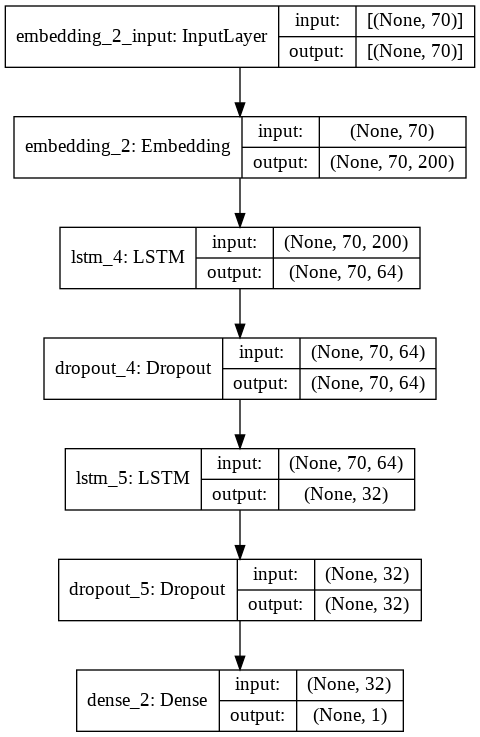

In [60]:
plot_model(model_lstm, to_file='LSTMbase_plot.png', show_shapes = True, show_layer_names = True)

In [16]:
history_lstm = model_lstm.fit(text_padded_train, labels_train, batch_size = 64, epochs = 3,
                                        validation_data = (text_padded_val, labels_val), 
                                        shuffle = True, verbose = 0)    

**Class imbalance**


In [17]:
class_weights_arr = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(labels_train),
                                                  y = labels_train)
class_weight_dict = {0: class_weights_arr[0], 1: class_weights_arr[1]}
print(class_weight_dict)

{0: 0.639905644257969, 1: 2.2869186145130103}


In [20]:
model_lstm_class = mod.model_LSTM(units_layer1 = 64, units_layer2 = 32, 
                                  vocab_len = vocab_length, embed_len = embed_length, max_len_tok = max_length_tokens, 
                                  embed_mat = embedding_matrix,
                                  n_dropout = 0.3, bi = False)
history_lstm_class = model_lstm_class.fit(text_padded_train, labels_train, batch_size = 64, epochs = 3,
                                          validation_data = (text_padded_val, labels_val), 
                                          shuffle = True, class_weight = class_weight_dict,
                                          verbose = 0)   

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 70, 200)           13641600  
_________________________________________________________________
lstm_2 (LSTM)                (None, 70, 64)            67840     
_________________________________________________________________
dropout_2 (Dropout)          (None, 70, 64)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 13,721,889
Trainable params: 80,289
Non-trainable params: 13,641,600
_____________________________________

**Bidirectionality**

Bidirectionality is operationalized by coding this specification into the LSTM layers. 

In [21]:
model_lstmB = mod.model_LSTM(units_layer1 = 64, units_layer2 = 32, 
                             vocab_len = vocab_length, embed_len = embed_length, max_len_tok = max_length_tokens, 
                             embed_mat = embedding_matrix,
                             n_dropout = 0.3, bi = True)
history_lstmB = model_lstmB.fit(text_padded_train, labels_train, batch_size = 64, epochs = 5,
                                validation_data = (text_padded_val, labels_val), 
                                shuffle = True, verbose = 0)       

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 70, 200)           13641600  
_________________________________________________________________
bidirectional (Bidirectional (None, 70, 128)           135680    
_________________________________________________________________
dropout_4 (Dropout)          (None, 70, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 13,818,561
Trainable params: 176,961
Non-trainable params: 13,641,600
____________________________________

**LSTM + Class imbalance + Bidirectionality**

In [22]:
# Bi + Class
model_lstmB_class = mod.model_LSTM(units_layer1 = 64, units_layer2 = 32, 
                                   vocab_len = vocab_length, embed_len = embed_length, max_len_tok = max_length_tokens, 
                                   embed_mat = embedding_matrix,
                                   n_dropout = 0.3, bi = True)
history_lstmB_class = model_lstmB_class.fit(text_padded_train, labels_train, batch_size = 64, epochs = 2,
                                            validation_data = (text_padded_val, labels_val), 
                                            shuffle = True, class_weight = class_weight_dict,
                                            verbose = 0) 

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 70, 200)           13641600  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 70, 128)           135680    
_________________________________________________________________
dropout_6 (Dropout)          (None, 70, 128)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 13,818,561
Trainable params: 176,961
Non-trainable params: 13,641,600
____________________________________

#### GRU

GRU was explored as a follow-up from LSTM, trying to achieve the best accuracy and recall while fixing the number of parameters as LSTM for a 'fair' comparison (Chung et al. 2014). The model specifications are similar for GRU than for LSTM, the only changes are:

**Architecture**
* Two GRU layers. The first with 80 units and the second with 32.

**Training specifications**
* Epochs are also decided individually for each variation.



**Base model**

In [23]:
model_gru = mod.model_GRU(units_layer1 = 80, units_layer2 = 32, 
                          vocab_len = vocab_length, embed_len = embed_length, max_len_tok = max_length_tokens, 
                          embed_mat = embedding_matrix,
                          n_dropout = 0.3, bi = False)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 70, 200)           13641600  
_________________________________________________________________
gru (GRU)                    (None, 70, 80)            67680     
_________________________________________________________________
dropout_8 (Dropout)          (None, 70, 80)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 32)                10944     
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,720,257
Trainable params: 78,657
Non-trainable params: 13,641,600
_____________________________________

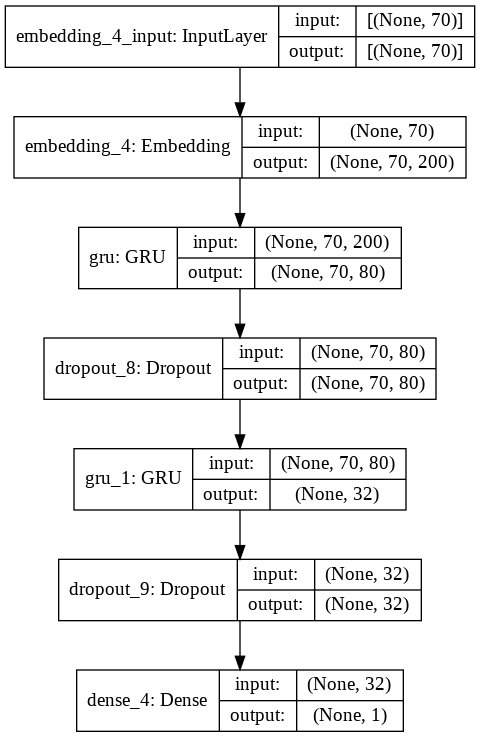

In [24]:
plot_model(model_gru, to_file='GRUbase_plot.png', show_shapes = True, show_layer_names = True)

In [25]:
history_gru = model_gru.fit(text_padded_train, labels_train, batch_size = 64, epochs = 3,
                            validation_data = (text_padded_val, labels_val), 
                            shuffle = True, verbose = 0) 

**Class imbalance**

In [26]:
model_gru_class = mod.model_GRU(units_layer1 = 80, units_layer2 = 32, 
                                vocab_len = vocab_length, embed_len = embed_length, max_len_tok = max_length_tokens, 
                                embed_mat = embedding_matrix,
                                n_dropout = 0.3, bi = False)
history_gru_class = model_gru_class.fit(text_padded_train, labels_train, batch_size = 64, epochs = 1,
                                  validation_data = (text_padded_val, labels_val), 
                                  shuffle = True, class_weight = class_weight_dict,
                                  verbose = 0) 

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 70, 200)           13641600  
_________________________________________________________________
gru_2 (GRU)                  (None, 70, 80)            67680     
_________________________________________________________________
dropout_10 (Dropout)         (None, 70, 80)            0         
_________________________________________________________________
gru_3 (GRU)                  (None, 32)                10944     
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 13,720,257
Trainable params: 78,657
Non-trainable params: 13,641,600
_____________________________________

**Bidirectionality**

In [27]:
model_gruB = mod.model_GRU(units_layer1 = 80, units_layer2 = 32, 
                           vocab_len = vocab_length, embed_len = embed_length, max_len_tok = max_length_tokens, 
                           embed_mat = embedding_matrix,
                           n_dropout = 0.3, bi = True)
history_gruB = model_gruB.fit(text_padded_train, labels_train, batch_size = 64, epochs = 3,
                              validation_data = (text_padded_val, labels_val), 
                              shuffle = True, verbose = 0) 

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 70, 200)           13641600  
_________________________________________________________________
bidirectional_4 (Bidirection (None, 70, 160)           135360    
_________________________________________________________________
dropout_12 (Dropout)         (None, 70, 160)           0         
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                37248     
_________________________________________________________________
dropout_13 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 13,814,273
Trainable params: 172,673
Non-trainable params: 13,641,600
____________________________________

**GRU + Class imbalance + Bidirectionality**

In [28]:
# Bi + Class
model_gruB_class = mod.model_GRU(units_layer1 = 80, units_layer2 = 32, 
                                 vocab_len = vocab_length, embed_len = embed_length, max_len_tok = max_length_tokens, 
                                 embed_mat = embedding_matrix,
                                 n_dropout = 0.3, bi = True)
history_gruB_class = model_gruB_class.fit(text_padded_train, labels_train, batch_size = 64, epochs = 2,
                                          validation_data = (text_padded_val, labels_val), 
                                          shuffle = True, class_weight = class_weight_dict,
                                          verbose = 0) 

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 70, 200)           13641600  
_________________________________________________________________
bidirectional_6 (Bidirection (None, 70, 160)           135360    
_________________________________________________________________
dropout_14 (Dropout)         (None, 70, 160)           0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 64)                37248     
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 65        
Total params: 13,814,273
Trainable params: 172,673
Non-trainable params: 13,641,600
____________________________________

#### Model evaluation

The performance metrics used to evaluate the results are: accuracy, precision, recall and Area under the Curve (AUC). Accuracy is not sensitive to class imbalance, which means that for datasets with a predominant class, such as the MMHS150K, the metric is overestimated as the dominant class is typically predicted with higher accuracy. Consequently, complimentary metrics are introduced. 



In [29]:
# LSTM
model_lstm_results = model_lstm.evaluate(text_padded_test, labels_test)
model_lstm_class_results = model_lstm_class.evaluate(text_padded_test, labels_test) # Class

model_lstmB_results = model_lstmB.evaluate(text_padded_test, labels_test) # Bidirectionality
model_lstmB_class_results = model_lstmB_class.evaluate(text_padded_test, labels_test) # Class + Bidirectionality

# GRU
model_gru_results = model_gru.evaluate(text_padded_test, labels_test)
model_gru_class_results = model_gru_class.evaluate(text_padded_test, labels_test) # Class

model_gruB_results = model_gruB.evaluate(text_padded_test, labels_test) # Bidirectionality
model_gruB_class_results = model_gruB_class.evaluate(text_padded_test, labels_test) # Class + Bidirectionality

print('ready')

313/313 [==============================] - 3s 9ms/step - loss: 0.6075 - accuracy: 0.6770 - precision_7: 0.6830 - recall_7: 0.6609 - auc_7: 0.7285
ready


### Results

The final performance metrics are presented in the following table. External models for the MMHS150K are presented for comparative purposes: the LSTM model for text estimated by Gomez et al. (2019); their Feature Concatenation Model (FCM), Gomez et al. (2019) best performing multimodal model (image, image text and text); and, Kumar et al. (2020) best multimodal model, Fusion.

| Model                      |  ACC  | Precision | Recall |  AUC  |
|----------------------------|:-----:|:---------:|:------:|:-----:|
| LSTM, Gomez et al. (2019) | 0.683 |     -     |    -   | 0.732 |
| LSTM-base                | 0.600 |   0.813   |  0.260 | 0.728 |
| LSTM-class               | 0.676 |   0.667   | 0.702 | 0.728 |
| LSTM-bi                 | 0.601 |   0.813   |  0.263 | 0.728 |
| LSTM-class_bi          | 0.676 |   0.686   |  0.650 | 0.728 |
| GRU-base                 | 0.613 |   0.802   |  0.300 | 0.728 |
| GRU-class                | 0.677 |   0.679   |  0.673 | 0.725 |
| GRU-bi                   | 0.589 |   0.826   |  0.227 | 0.728 |
| GRU-class_bi           | 0.677 |   0.683   |  0.660 | 0.728 |
| FCM, Gomez et al. (2019)  | 0.684 |     -     |    -   | 0.704 |
| Fusion, Kumar et al. (2020)  |   -   |   0.877   |    -   | 0.707 |

From these results I can answer the three research questions in the following way:

**(1) LSTM and GRU**

Using the same epochs during training, in terms of accuracy and recall, the base GRU model outperforms the LSTM. Both are tied under the AUC metric at 0.728. Nonetheless, the model with higher recall, identifies the greater proportion of test set tweets (70.2%) labeled as hate-speech, is the LSTM with class imbalance. 

The LSTM and GRU models and variatons outperform, in terms of the AUC metric, the multimodal proposals of Gomez et al. (2019) and Kumar et al. (2020). Simultaneously, these are slightly outperformed by Gomez et al. (2019) LSTM model for text. Although Gomez et al. (2019) do not report precision and recall, they do present an F metric of 0.703. From the interaction between the precision and recall of the models, I consider that I am not far off from the prediction performance.

The performance of my model compared with the multimodal approaches suggests an area of opportunity for tweet classification tasks. Based exclusively on this study, it is possible that hate-speech content in Twitter can be identified solely using text through less complex and more computationally-efficient models. 

My best performing model, the LSTM-class, outperforms both in terms of the AUC metric even though it has a simpler and less complex architecture. Kumar et al. (2020) best models have from 300,000 to 700,000, trainable parameters while the LSTM-class model has 80,000. Although I could not identify the specific number of FCM trainable parameters (Gomez et al., 2019), it appears more complex as it comprises of an LSTM model, an Inception architecture for image classification, and three fully-connected layers. Gomez et al. (2019) attributes this challenge to the noisy nature of the MMHS150K, they mention that only-text classification is affected by this variability and subjectivity which amounts when increasing other input formats.

**(2) Bidirectionality**

Comparing the base models performance with the variations which incorporate bidirectionality, I conclude that for this particular task and dataset, bidirectionality does not improve performance. 

**(3) Class**

The concerns from the authors cited in previous sections regarding the high class imbalance of the MMHS150K are evidentiated by the more-than-double boost in recall performance for both GRU and LSTM. Accuracy increases while not as much as recall due to a considerable decrease in precision for both models. This trade-off among recall and precision metrics uncovers the workings of giving a greater weight in the loss calculation for the underrepresented class (hate-speech tweets).

### Conclusion

The present hate-speech detection task through LSTM and GRU for the MMHS150K dataset arrives at similar performance metrics for, to the best of my knowledge, the only other text classification method in the literature. Also, my best performing model, a two-layer LSTM model with 0.3 dropout, outperforms multimodal approaches for the MMHS150K dataset. The results suggest that simple and efficient hate-speech detection in Twitter can be efficiently achieved for multimodal tweets using solely text. 
